# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Developed by:
1. Ranjit Patra - Group facilitator
2. Kanchan Singh

## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

Each video is a sequence of 30 frames (or images). The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

 
Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.


Your task is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects). We have withheld the test folder for evaluation purposes - your final model's performance will be tested on the 'test' set.

In [6]:
import numpy as np
import os
import PIL
import datetime
import os

import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [8]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30)
tf.random.set_seed(30)

Project Data directory path build, so that it can used in the project after

In [9]:
DATA_DIRECTORY = "datasets/Project_data"

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [10]:
train_doc = np.random.permutation(open(DATA_DIRECTORY + '/train.csv').readlines())
val_doc = np.random.permutation(open(DATA_DIRECTORY + '/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [92]:
train_doc[:5]

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n'],
      dtype='<U88')

In [104]:
# Prepare Gestures Dictionary
GESTURE_DICT = dict()

for item in train_doc:
    splits = item.strip().split(";")
    encoded_index = splits[2]
    gesture = splits[1]
    GESTURE_DICT[int(encoded_index)] = gesture.replace("_new", "").replace("_", " ").replace("Left Swipe Left Swipe", "Left Swipe")
    
GESTURE_DICT

{1: 'Right Swipe',
 3: 'Thumbs Down',
 0: 'Left Swipe',
 4: 'Thumbs Up',
 2: 'Stop'}

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

Create a generic abstract Base Model, and each model implementation will inherit the class and implement the model implementation.

In [55]:
import PIL
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from skimage.io import imread
from skimage.transform import resize as imresize

class AbstractModel:
    
    @property
    def model(self):
        if not self._model:
            self._model = self.define_model()
        return self._model
        
        
    def __init__(self, data_directory = DATA_DIRECTORY):
        self.data_directory = data_directory
        self.train_doc = np.random.permutation(open(data_directory + '/train.csv').readlines())
        self.val_doc = np.random.permutation(open(data_directory + '/val.csv').readlines())
        self.train_path = data_directory + '/train'
        self.val_path =  data_directory + '/val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
        print('# training sequences =', self.num_train_sequences)
        print('# validation sequences =', self.num_val_sequences)
        
        self._model = None

        
    def init_image_properties(self, image_width=100, image_height=100):
        self.image_width = image_width
        self.image_height = image_height
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
        return self
    
    def init_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        print ('# epochs =', num_epochs)
        print ('# batch size =', batch_size)
        print ('# frame to sample =', frames_to_sample)
        return self
    
    def generator(self, source_path, folder_list, batch_size=40): 
        print('Source path = ', source_path, '; batch size =', batch_size)
        #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels= self.generate_single_batch_data(source_path, t, batch, batch_size, img_idx)
                yield batch_data, batch_labels 


            # write the code for the remaining data points which are left after full batches
            remaining_seq=len(t) % batch_size
            if (remaining_seq != 0):
                batch_data, batch_labels = self.generate_single_batch_data(source_path, t, num_batches, batch_size, img_idx, remaining_seq)
                yield batch_data, batch_labels
    
    def generate_single_batch_data(self, source_path, folder_list, batch, batch_size, img_idx, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_len, 5)) # batch_labels is the one hot representation of the output
            
        for folder in range(seq_len): # iterate over the batch_size or remaining size
            imgs = os.listdir(source_path+'/'+ folder_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ folder_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                image_resized = imresize(image, (self.image_height, self.image_width, 3))

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    

            batch_labels[folder, int(folder_list[folder + (batch * batch_size)].strip().split(';')[2])] = 1
        return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
    
    def train(self, model):
        train_generator = self.generator(self.train_path, self.train_doc, self.batch_size)
        val_generator = self.generator(self.val_path, self.val_doc, self.batch_size)
        curr_dt_time = datetime.datetime.now()
        
        model_base_dir = "model"
        model_name = model_base_dir + "/" + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        
        if not os.path.exists(model_base_dir):
            os.mkdir(model_base_dir)
            
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history
    
    def summary(self, model, plot_image=False):
        model.summary()
        print("#Total Params: ", model.count_params())
        if plot_image:
            plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    def plot_accuracy_and_loss(self, history):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(history.history['loss'])   
        axes[0].plot(history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(history.history['categorical_accuracy'])   
        axes[1].plot(history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])
    
    def define_model(self):
        pass
        
        

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [9]:
class Conv3DModel1(AbstractModel):
    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=Conv3DModel1(data_directory=DATA_DIRECTORY)
conv_3d1.init_image_properties(image_height=40, image_width=40)
conv_3d1.init_hyperparams(frames_to_sample=18, batch_size=20, num_epochs=20)
conv_3d1_model = conv_3d1.define_model()
conv_3d1.summary(conv_3d1_model)
history = conv_3d1.train(conv_3d1_model)

# training sequences = 663
# validation sequences = 100
# epochs = 1
# batch size = 20
# frame to sample = 18
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 40, 40, 16)    1312      
                                                                 
 activation (Activation)     (None, 18, 40, 40, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 18, 40, 40, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 20, 20, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 20, 20, 32)     4128      
            

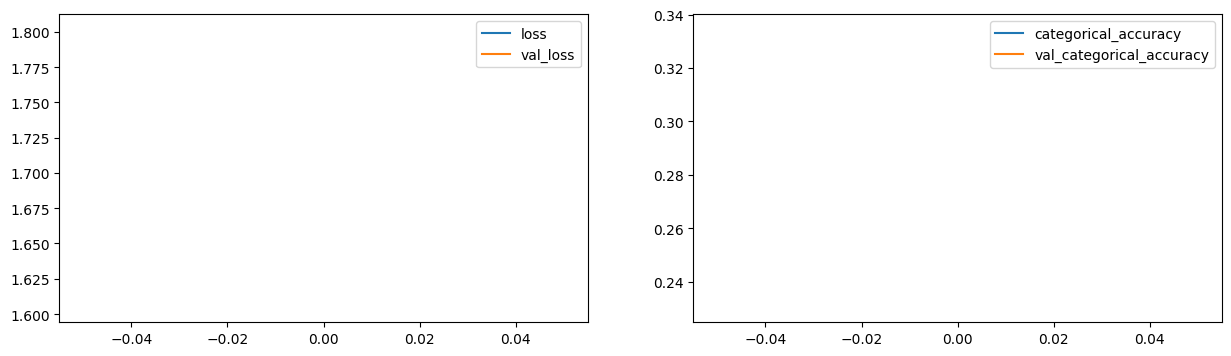

In [13]:
conv_3d1.plot_accuracy_and_loss(history)

#### Cropping and Resizing feature 
visualize some of the sample images

# training sequences = 663
# validation sequences = 100
# epochs = 1
# batch size = 20
# frame to sample = 20
Source path =  datasets/Project_data/val ; batch size = 20


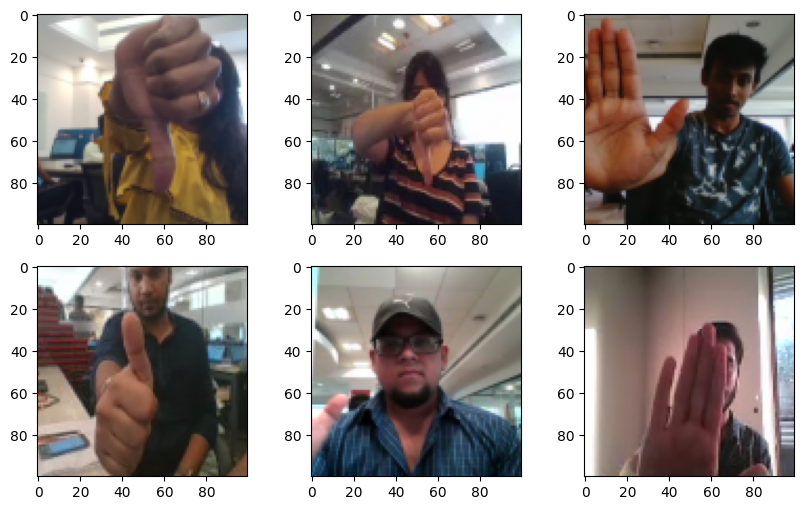

In [14]:
sample_generator=Conv3DModel1(data_directory=DATA_DIRECTORY)
sample_generator.init_image_properties(image_height=100, image_width=100)
sample_generator.init_hyperparams(frames_to_sample=20, batch_size=20, num_epochs=20)

sample=sample_generator.generator(sample_generator.val_path, sample_generator.val_doc, batch_size=20)
batch_data, batch_labels=next(sample)

fig = plt.figure(figsize=(10, 6))

for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(batch_data[i,15,:,:,:])

plt.show()

Let's start creating the models with fine tuning the batch size, image resulotion & epochs.

## Model 1 - Base Model - Batch Size = 40 and Epoch= 15.

In [15]:
class Conv3DModel1(AbstractModel):
    
    def define_model(self, filtersize=(3,3,3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d1=Conv3DModel1(data_directory=DATA_DIRECTORY)
conv_3d1.init_image_properties(image_height=160,image_width=160)
conv_3d1.init_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 15
# batch size = 40
# feame to sample = 20
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
         

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
training_output_model1 = conv_3d1.train(conv_3d1_model)

In [ ]:
conv_3d1.plot_accuracy_and_loss(training_output_model1)

Observation - Our model is seemingly overfitting.

## Model 2 - Reducing filter size to (2,2,2) & Image Resolution to 120x120

In [19]:
class Conv3DModel2(AbstractModel):
    
    def define_model(self,filtersize=(3,3,3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d2=Conv3DModel2(data_directory=DATA_DIRECTORY)
conv_3d2.init_image_properties(image_height=120,image_width=120)
conv_3d2.init_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=15)
conv_3d2_model=conv_3d2.define_model(filtersize=(2,2,2), dense_neurons=256, dropout=0.5)
conv_3d2_model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 1
# batch size = 30
# frame to sample = 16
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
          

In [21]:
print("Total Params:", conv_3d2_model.count_params())
training_output_model2=conv_3d2.train(conv_3d2_model)

Total Params: 1762613
Source path =  datasets/Project_data/train ; batch size = 30
23/23 [==============================] - ETA: 0s - loss: 1.7128 - categorical_accuracy: 0.4646Source path =  datasets/Project_data/val ; batch size = 30

Epoch 1: saving model to model/model_init_2023-05-2920_31_36.421116\model-00001-1.71282-0.46456-2.54231-0.21000.h5
23/23 [==============================] - 225s 10s/step - loss: 1.7128 - categorical_accuracy: 0.4646 - val_loss: 2.5423 - val_categorical_accuracy: 0.2100 - lr: 0.0010


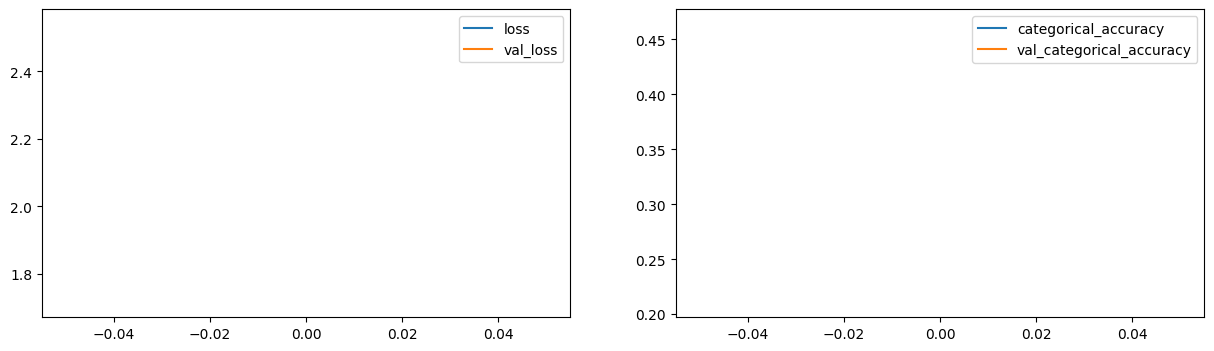

In [23]:
conv_3d2.plot_accuracy_and_loss(training_output_model2)

Model has a best validation accuracy of 79% and training accuracy of 83.52% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers to our model and see if we get any improvments.

## Model 3 -  Adding more layers to our previous model

In [29]:
class Conv3DModel1(AbstractModel):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
conv_3d3=Conv3DModel3(data_directory=DATA_DIRECTORY)
conv_3d3.init_image_properties(image_height=100,image_width=100)
conv_3d3.init_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=20)
conv_3d3_model=conv_3d3.define_model(dense_neurons=128,dropout=0.25)
conv_3d3_model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 1
# batch size = 30
# frame to sample = 16
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_66 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_49 (Conv3D)          (None, 16, 100, 100, 16)  6928      
                                                                 
 activation_49 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_nor

In [32]:
print("Total Params:", conv_3d3_model.count_params())
training_output_model3=conv_3d3.train(conv_3d3_model)

Total Params: 1489653
Source path =  datasets/Project_data/train ; batch size = 30
23/23 [==============================] - ETA: 0s - loss: 1.6133 - categorical_accuracy: 0.3816 Source path =  datasets/Project_data/val ; batch size = 30

Epoch 1: saving model to model/model_init_2023-05-2920_48_16.645912\model-00001-1.61330-0.38160-2.68995-0.16000.h5
23/23 [==============================] - 446s 19s/step - loss: 1.6133 - categorical_accuracy: 0.3816 - val_loss: 2.6900 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [ ]:
conv_3d3.plot_accuracy_and_loss(training_output_model3)

We achieve the best validation accuracy of 74% with the above experiment. Let's try and further reduce the number of parameters to see if it improves the performance.

## Model 4 - Further reducing the number of parameters

In [35]:
class Conv3DModel4(AbstractModel):
    
    def define_model(self, dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [43]:
conv_3d4=Conv3DModel4()
conv_3d4.init_image_properties(image_height=100,image_width=100)
conv_3d4.init_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d4_model=conv_3d4.define_model(dense_neurons=64,dropout=0.25)
conv_3d4_model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 1
# batch size = 20
# frame to sample = 16
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_76 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 8, 50, 50, 32)     13856     
         

In [44]:
print("Total Params:", conv_3d4_model.count_params())
training_output_model4=conv_3d4.train(conv_3d4_model)

Total Params: 398213
Source path =  datasets/Project_data/train ; batch size = 20
34/34 [==============================] - ETA: 0s - loss: 1.5213 - categorical_accuracy: 0.4193Source path =  datasets/Project_data/val ; batch size = 20

Epoch 1: saving model to model/model_init_2023-05-2921_04_26.565479\model-00001-1.52129-0.41931-2.22038-0.16000.h5
34/34 [==============================] - 187s 5s/step - loss: 1.5213 - categorical_accuracy: 0.4193 - val_loss: 2.2204 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [ ]:
conv_3d4.plot_accuracy_and_loss(training_output_model4)

We achieve the best validation accuracy of 79%. Let's keep on reducing the parameters till we achieve optimum accuracy.

## Model 5 - CNN-LSTM Model

In [58]:
class CNNLSTM1(AbstractModel):
    
    def define_model(self,lstm_cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [59]:
cnn_lstm1=CNNLSTM1()
cnn_lstm1.init_image_properties(image_height=120,image_width=120)
cnn_lstm1.init_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
cnn_lstm1_model=cnn_lstm1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnn_lstm1_model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 1
# batch size = 20
# frame to sample = 18
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_34 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
         

In [60]:
print("Total Params:", cnn_lstm1_model.count_params())
training_output_model5=cnn_lstm1.train(cnn_lstm1_model)

Total Params: 1657445
Source path =  datasets/Project_data/train ; batch size = 20
34/34 [==============================] - ETA: 0s - loss: 1.3924 - categorical_accuracy: 0.4178Source path =  datasets/Project_data/val ; batch size = 20

Epoch 1: saving model to model/model_init_2023-05-2921_17_04.366167\model-00001-1.39240-0.41780-1.62376-0.18000.h5
34/34 [==============================] - 218s 6s/step - loss: 1.3924 - categorical_accuracy: 0.4178 - val_loss: 1.6238 - val_categorical_accuracy: 0.1800 - lr: 0.0010


In [ ]:
cnn_lstm1.plot_accuracy_and_loss(training_output_model5)

## Model 6 - Transfer Learning using Mobilenet on CNN-RNN with GRU

In [61]:
from keras.applications import mobilenet

In [64]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class CNNRNNModelWithTransferLearning1(AbstractModel):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [68]:
rnn_cnn_tl1=CNNRNNModelWithTransferLearning1()
rnn_cnn_tl1.init_image_properties(image_height=120,image_width=120)
rnn_cnn_tl1.init_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)
rnn_cnn_tl1_model=rnn_cnn_tl1.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl1_model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 1
# batch size = 5
# frame to sample = 16
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_54 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
          

In [69]:
print("Total Params:", rnn_cnn_tl1_model.count_params())
training_output_model6=rnn_cnn_tl1.train(rnn_cnn_tl1_model)

Total Params: 3693253
Source path =  datasets/Project_data/train ; batch size = 5
133/133 [==============================] - ETA: 0s - loss: 0.9259 - categorical_accuracy: 0.6621Source path =  datasets/Project_data/val ; batch size = 5

Epoch 1: saving model to model/model_init_2023-05-2921_29_17.367650\model-00001-0.92593-0.66214-0.45144-0.85000.h5
133/133 [==============================] - 287s 2s/step - loss: 0.9259 - categorical_accuracy: 0.6621 - val_loss: 0.4514 - val_categorical_accuracy: 0.8500 - lr: 0.0010


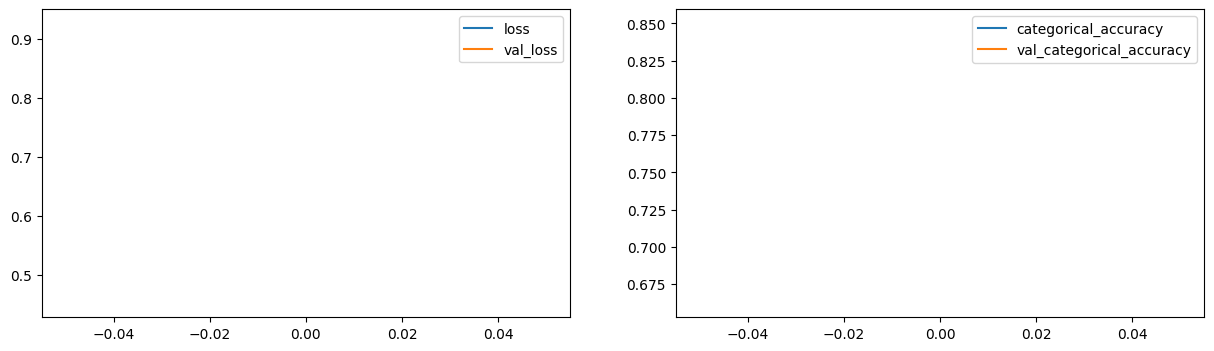

In [70]:
rnn_cnn_tl1.plot_accuracy_and_loss(training_output_model6)

### After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.
Reason:

- (Training Accuracy : 93%, Validation Accuracy : 85%)
- Number of Parameters(1,657,445)less according to other models performance
- Learning rate gradually decreacing after 16 Epoch

The best weights of CNN-LSTM: <model> (19 MB). we considered this weight for model testing, Let's have look at the performance below

## Load the selected model and perform Testing

In [71]:
import time
from keras.models import load_model
model = load_model('model/model_init_2023-05-2921_29_17.367650/model-00001-0.92593-0.66214-0.45144-0.85000.h5')

In [76]:
# Summarize the model.
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_54 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [77]:
test_generator=CNNRNNModelWithTransferLearning1()
test_generator.init_image_properties(image_height=120,image_width=120)
test_generator.init_hyperparams(frames_to_sample=16, batch_size=5, num_epochs=1)

g = test_generator.generator(test_generator.val_path, test_generator.val_doc, batch_size=5)
batch_data, batch_labels=next(g)

# training sequences = 663
# validation sequences = 100
# epochs = 1
# batch size = 5
# frame to sample = 16
Source path =  datasets/Project_data/val ; batch size = 5


In [78]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [107]:
# get the predictions
prediction_probabilities = model.predict(batch_data[:,:,:,:,:])

1/1 [==============================] - 0s 257ms/step


In [108]:
#print the prediction_probabilities
for i in prediction_probabilities:
    print(i)

[0.01762276 0.01205191 0.01721945 0.87437993 0.07872598]
[0.02076015 0.02413201 0.01510886 0.92335516 0.0166438 ]
[0.00381094 0.00211087 0.05185153 0.00219509 0.9400316 ]
[0.4455369  0.20375666 0.0701147  0.21607907 0.06451265]
[0.05957184 0.01775662 0.01570892 0.87581265 0.03114997]


In [111]:
predictions = np.argmax(prediction_probabilities, axis=1)

In [112]:
print(predictions)

[3 3 4 0 3]


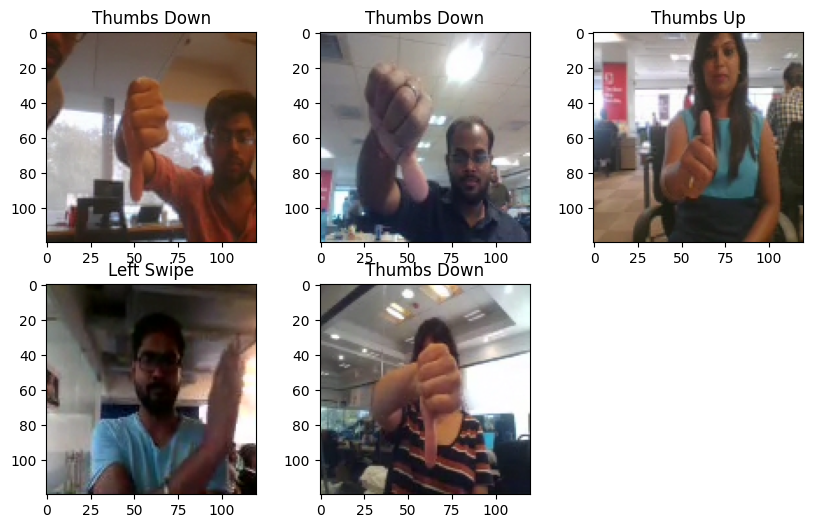

In [116]:
fig = plt.figure(figsize=(10, 6))

for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.title(GESTURE_DICT[predictions[i]])
    plt.imshow(batch_data[i,15,:,:,:])

plt.show()

In [ ]:
############################################################################################################################
#                                                                                                                          #               
#                                                Compiled By:                                                              #
#                                                1. Ranjit Patra - Group Facilitator                                       #
#                                                2. Kanchan Singh                                                          #
############################################################################################################################